# Capturing drone during Return to Home functionality

In most of the drones is active the Return to Home functionality (RTH) that is allows it to automatically return back to the Home location where the pilot is located using the shortest path possible. The RTH mode is automatically enabled in emergencies cases such low battery or loos of the signal for few seconds.


Is it possible for an attacker who want to capture the drone (i.e position D) to first jam the signal between the drone and the Global Navigation Satellite System and as consequence the UAV enters in the RTH mode. At this point the attacker spoof fake positions and send it to the UAV until it reach a certain point (i.e. turning point). The turning point is the point in which the line that connect the drone location and D is parallel with the line that connect the turning point itself to H. When we spoof this location the drones act as if it position is the turning point and so to RTH mode will proceed straight to reach the home as soon as possible. The drone position is different and in this way it will reach D instead of H allowing the attacker to take control of the drone.






> In the proposed simulation differently from the paper in which the attack has been proposed we have some constraint:

*   The speed is constant
*   Instead of using a greedy algoritħm to find the turning point a different approach has been used.
* Usually drones have mounted an operational limit of the GPS of 80 m/s, to prevent abnormal change of the GPS locationas that violate physical limits. This scenario is not taken in consideration in the computation of the turning point.

Moreover, as explained in the paper the optimal position for the capturing site is on the left of the home location, and initial position of the drone should be between them. In the esperiment performed in this simulation, the spoofing and capturing procedure is valid for both the configuration in which the home location is on the left or on the right of the initial drone location. The only constraint for the attack to work is that the drone must be in a position between these two points.





In [ ]:
# Function to simulate the movement of a drone from a given current position
# towards a specified destination at a defined speed, incorporating randomness
#to simulate the wind effect and the misurations errors
def move_towards_destination(current_position, destination, speed):
    direction = destination - current_position
    distance = np.linalg.norm(direction)
    if distance <= speed:
        new_position = destination
    else:
        if(distance>=speed*10):
          speed=2.*speed
          print("Speed changed to: ",speed)
        unit_direction = direction / distance
        movement = unit_direction * speed
        movement += np.random.normal(scale=0.8, size=2)
        new_position = current_position + movement
    return new_position


In [ ]:
import math

#This function has the purpose to find the turning point by just transalte the straight line that connect the points D and true loc to the points H,
# in order to find the turning point. In this way the real heading is parallel to the spoofed one.
def find_spoofed_trajectory(D, H, true_loc, fake_loc,n , Turning_point=False):
    current_real_position = true_loc[n]
    turning_point = find_turning_point(D,current_real_position,H)
    Turning_point = True
    print("Turning point found at: ",turning_point)
    print("current_real_pos: ",current_real_position)
    return turning_point,Turning_point


# Compute the length of the line between two points
def line_length(p1, p2):
    return math.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)


def find_turning_point(D, true_loc, H):
    original_length = line_length(D, true_loc)

    # Compute the heading of the line between D and true_loc
    heading = (true_loc[0] - D[0], true_loc[1] - D[1])

    # Normalize the heading
    heading_length = math.sqrt(heading[0]**2 + heading[1]**2)
    normalized_heading = (heading[0] / heading_length, heading[1] / heading_length)

    # Build the straight line from the same length and start from H
    turning_point = (H[0] + original_length * normalized_heading[0],
                     (H[1] + original_length * normalized_heading[1]))

    return turning_point


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def droneHeading(starting_point, H, D,capturing_distance,drone_speed=10):
    print("Jamming the connection between the drone and the GNSS")
    not_at_home = True  # boolean for drone's getting to home
    drone_speed = 10  # m/s
    new_loc = starting_point  # current drone's location
    n = 0
    turning_point=False
    true_loc = np.vstack([new_loc])
    print("Initial Drone Location: ", starting_point)
    while not_at_home:
      #Ideally here the jamming is started and the drone start to moving in the direction of H
      #Computing the angular coefficient we can find the line that connect the starting position and H, simulating the RTH
        if(n==0):
          print("Drone starts to back home from position: ",starting_point)
          new_loc = move_towards_destination(starting_point,H,drone_speed)
          true_loc = np.vstack([true_loc,new_loc])
          n += 1
          print("Drone is now at position: ",new_loc)

        #Once the drone starts to moving in the direction of H we can start spoofing fake locations
        if(n==1):
          print("Start spoofing...")
          #As the paper suggests the optimal first spoofed trajectory is the one that starts from the previous point in which the drone is moved
          #and ends exactly above H
          fake_location = np.array([H[0],new_loc[1]])
          fake_loc = true_loc
          fake_loc = np.vstack([fake_loc,fake_location])

          #The actual heading of the drone at this point is the same of the spoofed headind,(vertical down to H).
          #Here the speed has been modified for calculation reasons. If we consider speed 10, the heading is vertical down
          new_loc = move_towards_destination(new_loc,H,drone_speed)
          true_loc = np.vstack([true_loc, new_loc])
          n += 1

        #At this point the spoofed direction is moving on the right from the point H, and will reach the turning point.
        #Meanwhile the spoofed locations are on the right of H, whats happen to the drone is that it starts moving on the left towards D.
        #In the code this is done by computing: new_loc = move_towards_destination(new_loc,D,drone_speed)
        if(n>1) and turning_point==False:
          spoofed_loc, turning_point = find_spoofed_trajectory(D,H,true_loc,fake_loc,n)
          fake_loc = np.vstack([fake_loc, spoofed_loc])

          #Once the turning point has been found the drone is convinced to fly from that point straight to the home location, while it actually fly from S1 (in the plot) straight to D.
          new_loc = move_towards_destination(new_loc,D,drone_speed)
          true_loc = np.vstack([true_loc,new_loc])
          n +=1
        #Once the turning point has been found the drone will proceed by moving from the spoofed turning point to reach the location H.
        #What happens in reality is that the drone will proceed to move towards D in a parallel trajectory with respect to the spoofed one.
        #As before in order to simulate this behaviour we need to move the drone from the last position to D.
        if(turning_point==True):

          new_loc = move_towards_destination(new_loc,D,drone_speed)
          spoofed_loc = move_towards_destination(spoofed_loc,H,drone_speed)

          true_loc = np.vstack([true_loc, new_loc])
          fake_loc = np.vstack([fake_loc, spoofed_loc])
          n += 1
        print("Drone real position: ",new_loc)
        print("Drone spoofed position: ",spoofed_loc)

        # if drone is arrived to the capturing site then stops, otherwise continue to perform the operation in the previous if confition
        #In a real scenario a 5 meters range is sufficient to succesfully capturing the drone
        if(np.abs(D[0] - new_loc[0]) < capturing_distance) and (np.abs(D[1] - new_loc[1]) < capturing_distance):
          not_at_home = False
          print("Spoofing terminated, the drone has been captured")
          break
    print("Collection of the actual locations where the drone moved: ",true_loc)
    print("Collection of the fake locations where the drone moved: ",fake_loc)
    return true_loc, fake_loc



def plot(locations, spoofed_locations,home_location,spoofed_home_location,starting_point):
  x_coords = locations[:, 0]
  y_coords = locations[:, 1]


  x_coords_spoofed = spoofed_locations[:, 0]
  y_coords_spoofed = spoofed_locations[:, 1]

  ideal_RTH_trajectory = np.vstack([starting_point,home_location])
  vertical_line = np.vstack([spoofed_locations[2,:],home_location])


  plt.figure(figsize=(12, 10))
  plt.plot(ideal_RTH_trajectory[:, 0],ideal_RTH_trajectory[:, 1], linestyle='dashed', color='y', label = "Ideal Trajectory")
  plt.plot(vertical_line[:,0],vertical_line[:,1],linestyle='dotted', color='y')
  plt.plot(x_coords, y_coords, marker='.', linestyle='-', color='b',label="Actual Path")
  plt.plot(x_coords_spoofed, y_coords_spoofed, marker='.', linestyle='solid', color='g', label="Spoofed Path")
  plt.scatter(starting_point[0], starting_point[1], marker='o', color='r', label='Initial Location')
  plt.scatter(home_location[0], home_location[1], marker='o', color='g', label='H')
  plt.scatter(spoofed_home_location[0], spoofed_home_location[1], marker='x', color='r', label='D')
  plt.text(spoofed_locations[0, 0], spoofed_locations[0, 1], 'Jamming starts', fontsize=9, ha='right')
  plt.text(spoofed_locations[1, 0], spoofed_locations[1, 1], 'Spoofing start', fontsize=9, ha='right')
  plt.text(spoofed_locations[3, 0], spoofed_locations[3, 1], "Turning point-S'2", fontsize=9, ha='left')
  plt.text(locations[3, 0],locations[3, 1], 'S2', fontsize=9, ha='left')
  plt.text(locations[2, 0], locations[2, 1], "S1", fontsize=9, ha='left')
  plt.text(spoofed_locations[2, 0], spoofed_locations[2, 1], "S'1", fontsize=9, ha='left')
  plt.title('Drone Path')
  plt.xlabel('X Coordinate')
  plt.ylabel('Y Coordinate')
  plt.legend()
  plt.grid(True)
  plt.show()








Jamming the connection between the drone and the GNSS
Initial Drone Location:  [30. 35.]
Drone starts to back home from position:  [30. 35.]
Drone is now at position:  [36.08567727 26.75658411]
Start spoofing...
Turning point found at:  (89.16713092438744, 16.90287464253705)
current_real_pos:  [41.16713092 16.90287464]
Drone real position:  [23.29154598  7.18072937]
Drone spoofed position:  [79.29720817 14.3165815 ]
Drone real position:  [12.26645586  4.15521968]
Drone spoofed position:  [68.98824808 10.22874578]
Drone real position:  [2.06273312 2.23808211]
Drone spoofed position:  [59.99263465  6.61255841]
Spoofing terminated, the drone has been captured
Collection of the actual locations where the drone moved:  [[30.         35.        ]
 [36.08567727 26.75658411]
 [41.16713092 16.90287464]
 [31.10472998 12.60002242]
 [23.29154598  7.18072937]
 [12.26645586  4.15521968]
 [ 2.06273312  2.23808211]]
Collection of the fake locations where the drone moved:  [[30.         35.        ]
 [

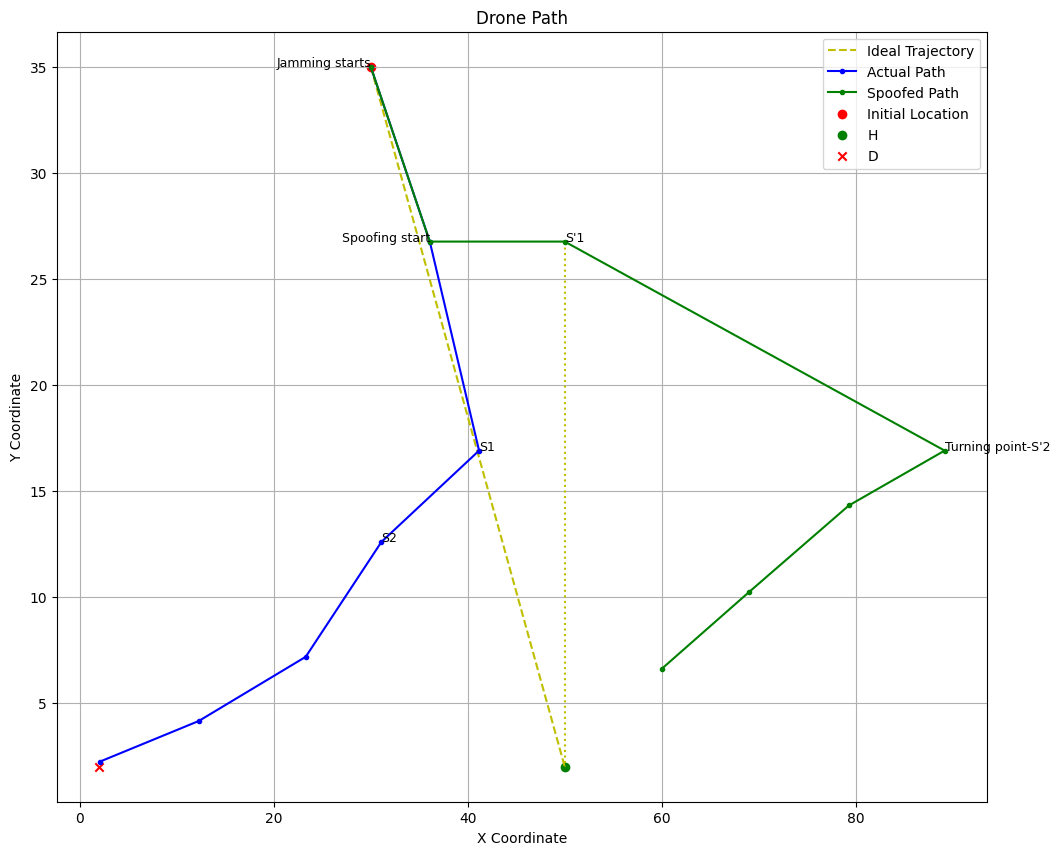

In [ ]:
starting_point = np.array([30. , 35.])
home_location = np.array([50. , 2.])
fake_home_location = np.array([2. , 2.])

true_locations,spoofed_locations = droneHeading(starting_point, home_location, fake_home_location,0.5,drone_speed=10.)

plot(true_locations,spoofed_locations, home_location, fake_home_location, starting_point)

As we can see from the plot above, the drone enters the RTH mode and start, following the most direct route to reach the destination point H. Subsequently, the spoofing attack is initiated, introducing the spoofed location denoted as S'1, strategically aligned with H along the X coordinate axis. Concurrently, the drone continues its approach toward the authentic point H.

At this point the turning point is found with the technique explained above and from this point both the heading, the real one and the spoofed one are paralell and point to D and to H respectivetely.

Jamming the connection between the drone and the GNSS
Initial Drone Location:  [101. 456.]
Drone starts to back home from position:  [101. 456.]
Speed changed to:  20.0
Drone is now at position:  [106.00882181 436.40104366]
Start spoofing...
Speed changed to:  20.0
Turning point found at:  (312.52251050936036, 415.61808641547566)
current_real_pos:  [110.52251051 415.61808642]
Speed changed to:  20.0
Speed changed to:  20.0
Speed changed to:  20.0
Drone real position:  [101.46133654 377.91012267]
Drone spoofed position:  [308.615978   395.35929188]
Speed changed to:  20.0
Speed changed to:  20.0
Drone real position:  [ 95.29364274 359.8017923 ]
Drone spoofed position:  [302.94619485 376.20517269]
Speed changed to:  20.0
Speed changed to:  20.0
Drone real position:  [ 91.28174658 339.74445898]
Drone spoofed position:  [300.09803146 356.98513852]
Speed changed to:  20.0
Speed changed to:  20.0
Drone real position:  [ 85.98783957 320.98062124]
Drone spoofed position:  [293.77346887 337.466

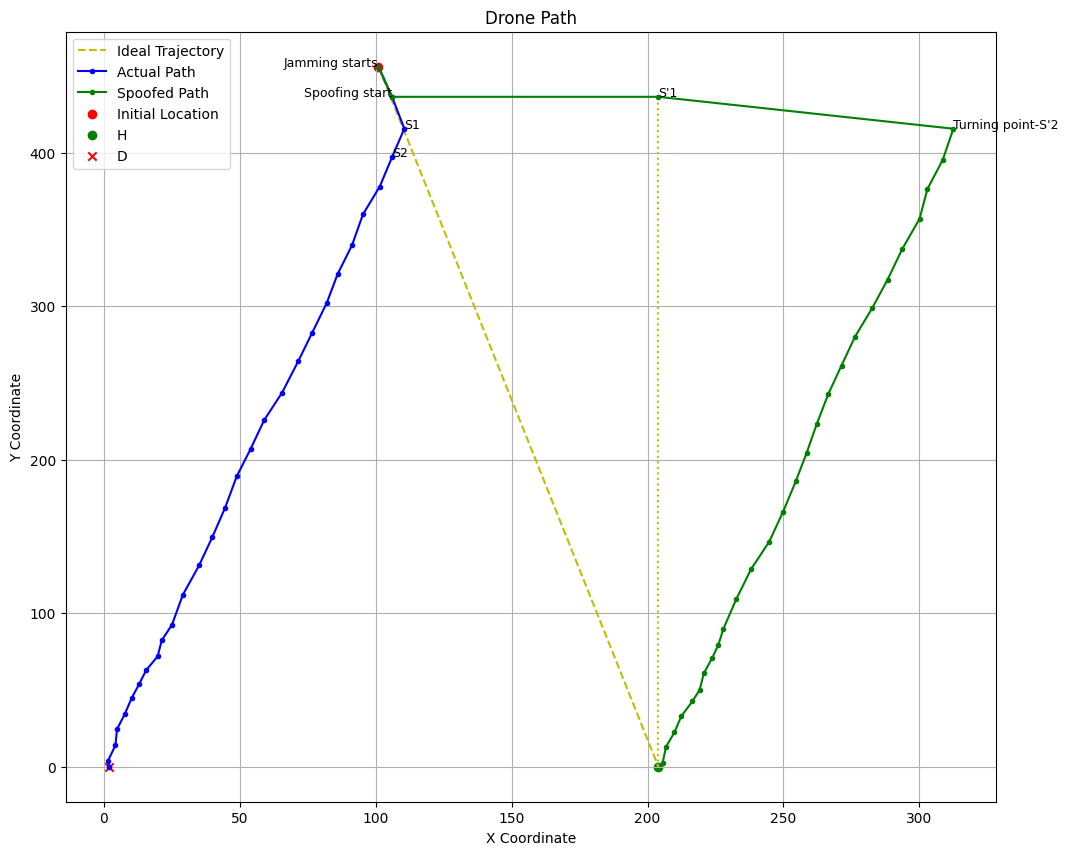

In [ ]:
starting_point = np.array([101. , 456.])
home_location = np.array([204. , 0.])
fake_home_location = np.array([2. , 0.])

true_locations,spoofed_locations=droneHeading(starting_point, home_location, fake_home_location,3,drone_speed = 15)

plot(true_locations,spoofed_locations, home_location, fake_home_location, starting_point)

Jamming the connection between the drone and the GNSS
Initial Drone Location:  [101. 456.]
Drone starts to back home from position:  [101. 456.]
Speed changed to:  20.0
Drone is now at position:  [ 96.7554988  438.08210957]
Start spoofing...
Speed changed to:  20.0
Turning point found at:  (-109.5468579441421, 416.5637852874483)
current_real_pos:  [ 92.45314206 416.56378529]
Speed changed to:  20.0
Speed changed to:  20.0
Speed changed to:  20.0
Drone real position:  [101.14104344 377.35783012]
Drone spoofed position:  [-104.16081779  396.72403963]
Speed changed to:  20.0
Speed changed to:  20.0
Drone real position:  [107.12186346 358.59088935]
Drone spoofed position:  [-98.57810591 379.74669201]
Speed changed to:  20.0
Speed changed to:  20.0
Drone real position:  [112.83009592 339.01761673]
Drone spoofed position:  [-93.87867803 360.34121793]
Speed changed to:  20.0
Speed changed to:  20.0
Drone real position:  [118.63117179 318.58238751]
Drone spoofed position:  [-88.7142241  341.17

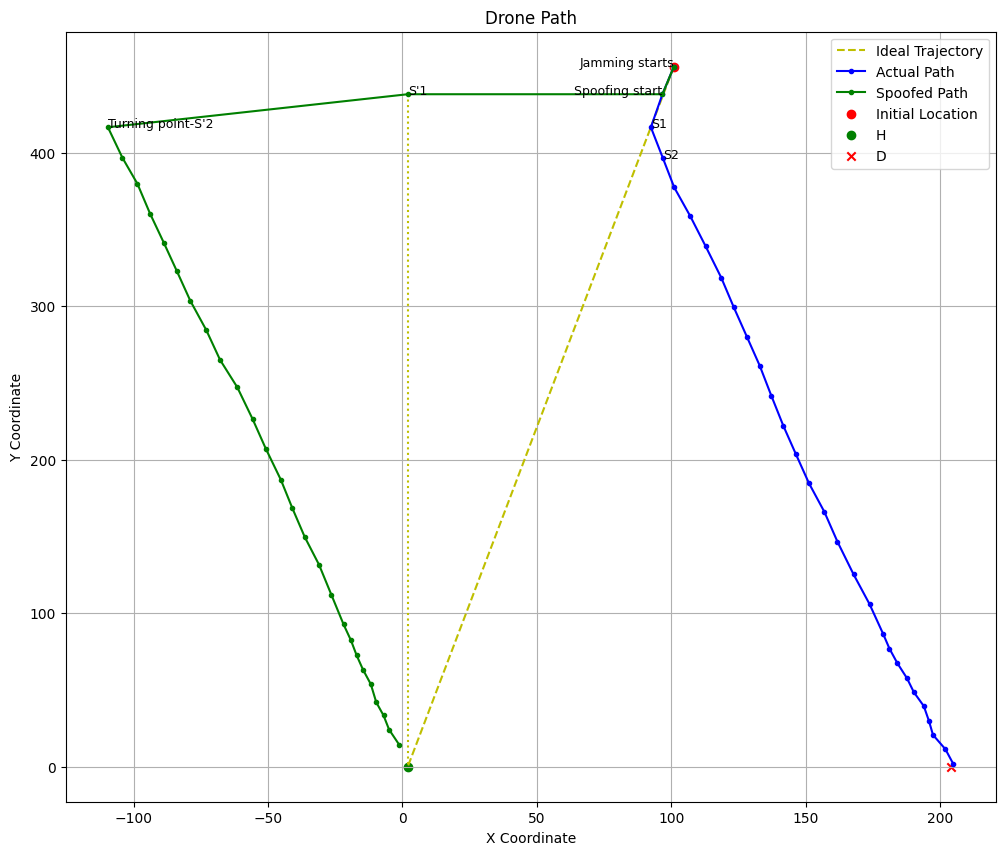

In [ ]:
starting_point = np.array([101. , 456.])
home_location = np.array([2. , 0.])
fake_home_location = np.array([204. , 0.])

true_locations,spoofed_locations=droneHeading(starting_point, home_location, fake_home_location,3,drone_speed=15)

plot(true_locations,spoofed_locations, home_location, fake_home_location, starting_point)

From the plot above we can notice the second configuration, in which the Home location is on the left of the drone initial position and the capturing site is on the right side of it.


---
Concluding, this attack simulation is working as expected. More work could be done by implementing and enhancing the reality of the attack, so by implementing this attack into a real drone simulator with actual jamming and spoofing components in order to simulate a real attacking scenario.
